In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [235]:
def get_col(fn, col_name):
    df = pd.read_csv(fn)
    return df[col_name].values

In [236]:
iglm_fn = 'data/unguided_cdr/iglm_fixed_samples_labeled_hcdr1.csv'
iglm_data = get_col(iglm_fn, 'seq_recovery')
iglm_med = np.median(iglm_data)

nosc_fn = 'data/unguided_cdr/gaussian_fixed_length=True_samples_labeled_hcdr1.csv'
nosc_data = get_col(nosc_fn, 'seq_recovery')
nosc_med = np.median(nosc_data)

nosd_fn = 'data/unguided_cdr/mlm_fixed_length=True_samples_labeled_hcdr1.csv'
nosd_data = get_col(nosd_fn, 'seq_recovery')
nosd_med = np.median(nosd_data)

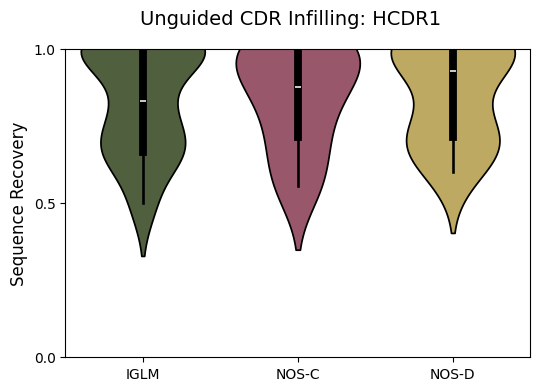

In [237]:
data_violin = {
    'IGLM': iglm_data,
    'NOS-C': nosc_data,
    'NOS-D': nosd_data
}

data_bar = {
    'Algorithm': ['IGLM', 'NOS-C', 'NOS-D'],
    'Median Sequence Recovery': [iglm_med, nosc_med, nosd_med]
}

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

group_names = []
values = []
for group, samples in data_violin.items():
    group_names.extend([group] * len(samples))
    values.extend(samples)

df_v = pd.DataFrame({"Algorithm": group_names, "Sequence Recovery": values})
sns.violinplot(x='Algorithm', y='Sequence Recovery', data=df_v, inner='box', palette=['#506538', '#A44C68', '#CCB252'], hue='Algorithm', linecolor='black', ax=axes)
axes.set_ylim(top=1)
axes.set_xlabel('')
axes.set_ylabel('Sequence Recovery', fontsize=12)
axes.tick_params(axis='both', which='major', labelsize=10)
axes.set_yticks(np.linspace(0, 1, 3))

fig.suptitle('Unguided CDR Infilling: HCDR1', fontsize=14)

plt.show()


In [240]:
lambda_params = [10.0, 1.0, 0.1, 0.01, 0.001]
mu_params = [1.0]
K_params = [10]
order_params = ['first']
return_best_params = [True]

nosd_ll = []
nosc_ll = []
nosd_beta_sheet = []
nosc_beta_sheet = []
pplm_ll = []
pplm_beta_sheet = []

data_map = {
    "mlm_ll" : nosd_ll,
    "gaussian_ll": nosc_ll,

    "mlm_beta_sheet": nosd_beta_sheet,
    "gaussian_beta_sheet": nosc_beta_sheet
}

ll_data = []
beta_sheet_data = []

for lam in lambda_params:
    for mu in mu_params:
        for K in K_params:
            for order in order_params:
                for return_best in return_best_params:
                    curr = {}
                    for nos in ["mlm", "gaussian"]:
                        guid_fn = f"/home/shai/NOS/guidance_results/{nos}/{nos}_fixed_length=True_autoregressive_sample=False_step_size={mu}_stability_coef={lam}_num_steps={K}_guidance_layer={order}_return_best={return_best}_samples_labeled.csv"
                        try:
                            ll = -get_col(guid_fn, 'lm_nll')
                            beta_sheet = get_col(guid_fn, 'ss_perc_sheet')
                            seq_recovery = get_col(guid_fn, 'seq_recovery')
                        except FileNotFoundError as e:
                            print(f"Missing: (Alg = {nos}, λ = {lam}, µ = {mu}, K = {K}, layer = {order}, return_best = {return_best})")
                            continue
                        #med_ll = np.median(ll)
                        #med_beta = np.median(beta_sheet)
                        #data_map[nos + "_ll"].append(float(med_ll))
                        #data_map[nos + "_beta_sheet"].append(float(med_beta))
                        data_map[nos + "_ll"].extend([float(x) for x in ll])
                        data_map[nos + "_beta_sheet"].extend([float(x) for x in beta_sheet])

stability_params = [0.0, 0.001, 0.01, 0.1, 1.0]
step_size_params = [1.7]
steps_params = [10]
for step_size in step_size_params:
    for stability in stability_params:
        for steps in steps_params:
            pplm_fn = f"/home/shai/NOS/guidance_results/pplm/iglm_fixed_length=True_step_size={step_size}_stability_coef={stability}_num_steps={steps}_samples_labeled.csv"
            try:
                ll = -get_col(pplm_fn, 'lm_nll')
                beta_sheet = get_col(pplm_fn, 'ss_perc_sheet')
            except FileNotFoundError as e:
                print(f"Missing: (Alg = pplm, step_size = {step_size}, stability = {stability}, steps = {steps})")
                continue
            #med_ll = np.median(ll)
            #med_beta = np.median(beta_sheet)
            #pplm_ll.append(float(med_ll))
            #pplm_beta_sheet.append(float(med_beta))
            pplm_ll.extend([float(x) for x in ll])
            pplm_beta_sheet.extend([float(x) for x in beta_sheet])

ll_data.extend(pplm_ll)
ll_data.extend(nosc_ll)
ll_data.extend(nosd_ll)
beta_sheet_data.extend(pplm_beta_sheet)
beta_sheet_data.extend(nosc_beta_sheet)
beta_sheet_data.extend(nosd_beta_sheet)

Missing: (Alg = gaussian, λ = 1.0, µ = 1.0, K = 10, layer = first, return_best = True)
Missing: (Alg = gaussian, λ = 0.1, µ = 1.0, K = 10, layer = first, return_best = True)
Missing: (Alg = gaussian, λ = 0.001, µ = 1.0, K = 10, layer = first, return_best = True)


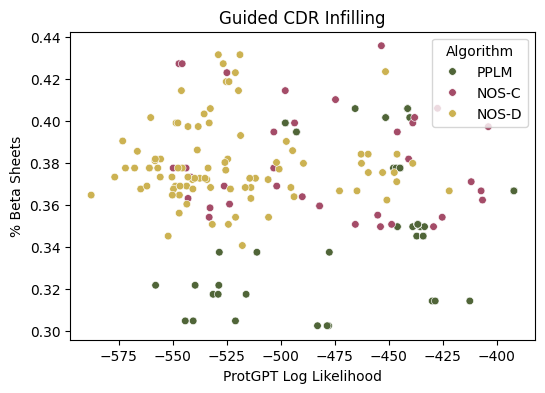

In [241]:
data = {
    "ProtGPT Log Likelihood": ll_data,
    "% Beta Sheets": beta_sheet_data,
    "Algorithm": ["PPLM"] * len(pplm_ll) + ["NOS-C"] * len(nosc_ll) + ["NOS-D"] * len(nosd_ll)
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))

ax = sns.scatterplot(data=df, x="ProtGPT Log Likelihood", y="% Beta Sheets", hue="Algorithm", palette=['#506538', '#A44C68', '#CCB252'], s=30)
plt.title('Guided CDR Infilling')
#sns.lineplot(data=df, x="ProtGPT Log Likelihood", y="% Beta Sheets", hue="Algorithm", palette=['#506538', '#A44C68', '#CCB252'], legend=False)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()